# Transfer learning with flowers

This is just an expiriment to learn how to use pretrained networks while still using interesting data

In [1]:
import numpy as np
import shutil
import os
from IPython.display import display
from PIL import Image
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as k
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, ReduceLROnPlateau

C:\Users\Administrator\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [16]:
all_data_dir = './input/flowers/'
train_data_dir = './input/train/'
test_data_dir = './input/test/'
test_split = 0.3
img_width = 128
img_height = 128
num_channels = 3
hidden_units = 1024
dropout_rate = 0.5
num_classes = 5
batch_size = 16
epochs = 10

In [6]:
def split_dataset_into_test_and_train_sets(all_data_dir, training_data_dir, testing_data_dir, testing_data_pct):
    # Recreate testing and training directories
    if testing_data_dir.count('/') > 1:
        shutil.rmtree(testing_data_dir, ignore_errors=False)
        os.makedirs(testing_data_dir)
        print("Successfully cleaned directory " + testing_data_dir)
    else:
        print("Refusing to delete testing data directory " + testing_data_dir + " as we prevent you from doing stupid things!")

    if training_data_dir.count('/') > 1:
        shutil.rmtree(training_data_dir, ignore_errors=False)
        os.makedirs(training_data_dir)
        print("Successfully cleaned directory " + training_data_dir)
    else:
        print("Refusing to delete testing data directory " + training_data_dir + " as we prevent you from doing stupid things!")

    num_training_files = 0
    num_testing_files = 0

    for subdir, dirs, files in os.walk(all_data_dir):
        category_name = os.path.basename(subdir)

        # Don't create a subdirectory for the root directory
        print(category_name + " vs " + os.path.basename(all_data_dir))
        if category_name == os.path.basename(all_data_dir):
            continue

        training_data_category_dir = training_data_dir + '/' + category_name
        testing_data_category_dir = testing_data_dir + '/' + category_name

        if not os.path.exists(training_data_category_dir):
            os.mkdir(training_data_category_dir)

        if not os.path.exists(testing_data_category_dir):
            os.mkdir(testing_data_category_dir)

        for file in files:
            input_file = os.path.join(subdir, file)
            if np.random.rand(1) < testing_data_pct:
                shutil.copy(input_file, testing_data_dir + '/' + category_name + '/' + file)
                num_testing_files += 1
            else:
                shutil.copy(input_file, training_data_dir + '/' + category_name + '/' + file)
                num_training_files += 1

    print("Processed " + str(num_training_files) + " training files.")
    print("Processed " + str(num_testing_files) + " testing files.")

In [8]:
split_dataset_into_test_and_train_sets(all_data_dir, train_data_dir, test_data_dir, test_split)

Successfully cleaned directory ./input/test/
Successfully cleaned directory ./input/train/
 vs 
daisy vs 
dandelion vs 
rose vs 
sunflower vs 
tulip vs 
Processed 2963 training files.
Processed 1363 testing files.


In [3]:
train_datagen = ImageDataGenerator(
        rescale=1.0/255, # Normalize input
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=15, # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

test_datagen = ImageDataGenerator(
        rescale=1.0/255, # Normalize input
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=15, # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

In [4]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size = (img_height, img_width),
    batch_size = batch_size, 
    class_mode = "categorical")

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size = (img_height, img_width),
    class_mode = "categorical",
    shuffle=False)

Found 2960 images belonging to 5 classes.
Found 1363 images belonging to 5 classes.


## Transfer model

Trying out a transfer model. Testing VGG since it is a classic. For more performance I would chose Inception V3 or something. Perhaps VGG19 is not so wise since it is so large, but you live you learn...

In [5]:
transfered_model = applications.VGG19(
    weights = "imagenet", 
    include_top=False, 
    input_shape = (img_width, img_height, num_channels))

In [6]:
transfered_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
__________

In [7]:
for layer in transfered_model.layers[:5]:
    layer.trainable = False

In [8]:
x = transfered_model.output
x = Flatten()(x)
x = Dense(hidden_units, activation="relu")(x)
x = Dropout(dropout_rate)(x)
x = Dense(hidden_units, activation="relu")(x)
predictions = Dense(num_classes, activation="softmax")(x)

In [9]:
model = Model(inputs = transfered_model.input, outputs = predictions)

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
__________

In [11]:
model.compile(
    loss = "categorical_crossentropy", 
    optimizer = optimizers.SGD(lr=0.00005, momentum=0.9), metrics=["accuracy"])

In [12]:
checkpoint = ModelCheckpoint(
    "vgg19_training.h5", 
    monitor='val_acc', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=False, 
    mode='auto', 
    period=1)

lr_reduction = ReduceLROnPlateau(
    monitor='loss', 
    patience=3,
    verbose=1,
    factor=0.5)

early = EarlyStopping(
    monitor='val_acc', 
    min_delta=0, 
    patience=10, 
    verbose=1, 
    mode='auto')

In [13]:
train_samples = 2960
test_samples = 1363

In [14]:
model.load_weights('vgg19_finished.h5')

In [17]:
model.fit_generator(train_generator,
                    epochs = epochs, 
                    validation_data = test_generator,
                    verbose = 1, 
                    steps_per_epoch=train_samples // batch_size, 
                    callbacks=[checkpoint, lr_reduction, early])

Epoch 1/10
185/185 [==============================] - 1079s 6s/step - loss: 0.0434 - acc: 0.9872 - val_loss: 0.6785 - val_acc: 0.8584

In [18]:
model.save('vgg19_finished.h5')

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [13]:
model.load_weights('vgg19_training.h5')

In [34]:
model.evaluate_generator(test_generator)

[0.6629045000429636, 0.8606016139553823]

In [35]:
target_names = ['Daisy', 'Dandelion', 'Rose', 'Sunflower', 'Tulip']

In [36]:
sample_data = test_generator.next()

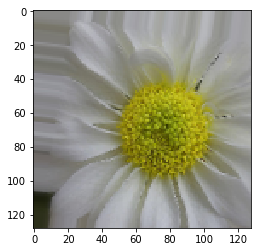

In [37]:
plt.imshow(sample_data[0][0,:,:,:])

In [47]:
img_index = 7
y = target_names[np.argmax(sample_data[1][img_index, :])]
y_pred = target_names[np.argmax(model.predict(np.reshape(sample_data[0][img_index, :], [1,128,128,3])))]
print('Correct: ', y, '\nPredicted: ', y_pred)

Correct:  Daisy 
Predicted:  Daisy


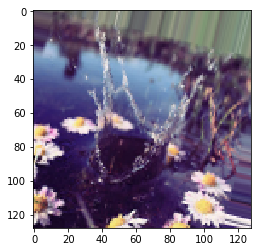

In [39]:
plt.imshow(sample_data[0][img_index, :])

In [48]:
Y_pred = model.predict_generator(test_generator)
Y_pred = np.argmax(Y_pred, axis=1)

In [49]:
target_names[Y_pred[0]]

'Daisy'

In [50]:
target_names[test_generator.classes[0]]

'Daisy'

In [51]:
from sklearn.metrics import confusion_matrix, classification_report

In [52]:
cm = confusion_matrix(test_generator.classes, Y_pred)
print(cm)
print()
print(classification_report(test_generator.classes, Y_pred, target_names=target_names))

[[198  17  13   8   8]
 [ 13 285   4   7   9]
 [  4   5 194   4  37]
 [  3   6   3 228  10]
 [  9   6  17   6 269]]

             precision    recall  f1-score   support

      Daisy       0.87      0.81      0.84       244
  Dandelion       0.89      0.90      0.89       318
       Rose       0.84      0.80      0.82       244
  Sunflower       0.90      0.91      0.91       250
      Tulip       0.81      0.88      0.84       307

avg / total       0.86      0.86      0.86      1363



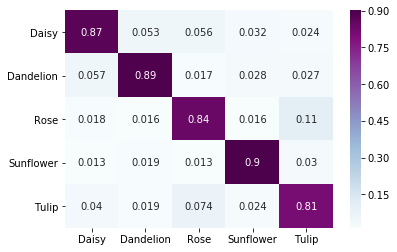

In [78]:
sns.heatmap(cm/cm.sum(axis=0), annot=True, xticklabels=target_names, yticklabels=target_names, cmap='BuPu')